# ELE510 Project - Hand Gesture Detection

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import codecs
import json
from tqdm import tqdm
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
# Hide GPU due to small model
tf.config.set_visible_devices([], 'GPU')

## Loading and testing train data

Each image has a an annotation. The annotation consists of the fields: `bboxes`, `labels`, `landmarks`, `leading_conf`, `leading_hand`, and `user_id`. <br>
<br>
bboxes - Normalized coordinates for boxes around detected hands. `[top left X pos, top left Y pos, width, height]`. <br>
labels - List of class labels of the detected gestures. e.g. `like`, `peace`, `no_gesture`. <br>
landmarks - List of normalized hand landmarks `[x, y]`. <br>
leading_conf - Leading confidence for `leading_hand`.  <br>
leading_hand - `right` or `left` for hand which showing gesture. <br>
user_id - subject id.

In [5]:
# Adding all annotation files to a list
files = []
for file in os.listdir("data/train"):
    if file.endswith(".json"):
        files.append(os.path.join("data/train", file))
        
# Defining all classes
class_names = [
       'call',
       'dislike',
       'fist',
       'four',
       'like',
       'mute',
       'ok',
       'one',
       'palm',
       'peace',
       'peace_inverted',
       'rock',
       'stop',
       'stop_inverted',
       'three',
       'three2',
       'two_up',
       'two_up_inverted']

# Adding train images to dictionary
train_img_dict = {}
for c in class_names:
    train_img_dict[c] = []
    for img_file in os.listdir("images/train_original/" + c):
        train_img_dict[c].append(img_file.replace('.jpg', ''))

# Exporting training json data from file to dictionary
data = {}
classindex = 0
for file in files:
    current_class = class_names[classindex]
    class_annotations = {}
    with codecs.open(file,'r','utf-8') as f: 
        annotations = json.load(f)
        for annotation in annotations:
            if annotation in train_img_dict[current_class]:
                class_annotations[annotation] = annotations[annotation]
    classindex += 1
    data[current_class] = class_annotations

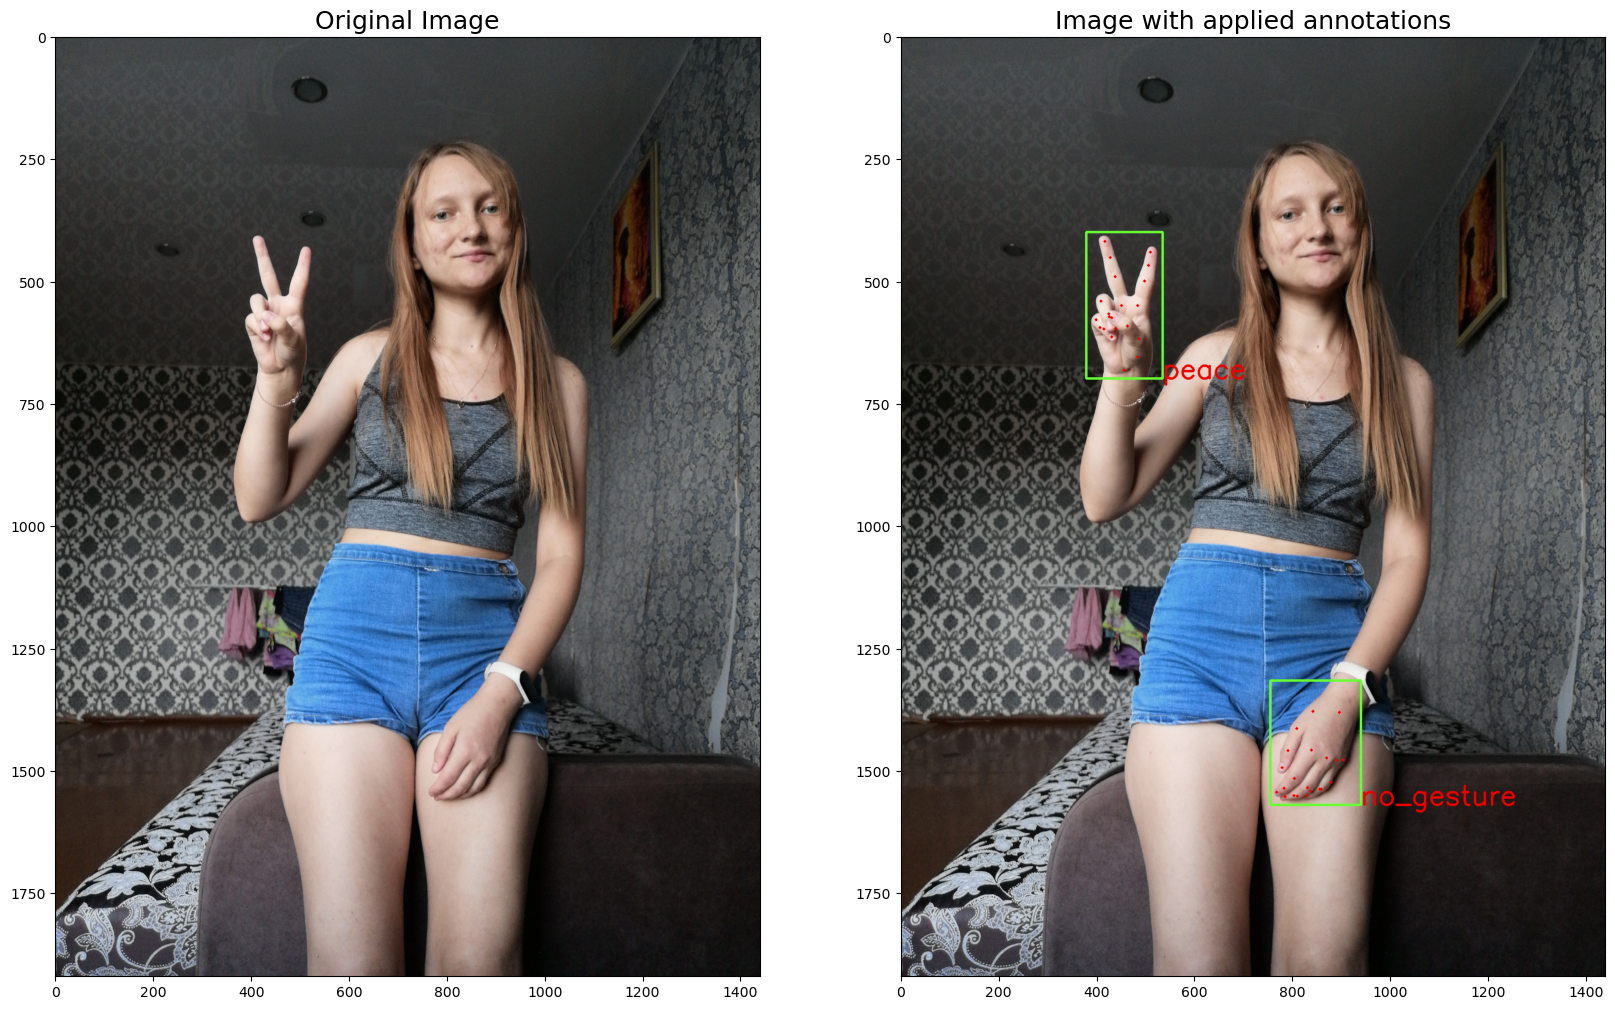

In [87]:
# Testing data in RGB format
image_name = '3e398fdd-1a41-4f68-b425-8be6bcdeb6e6'
im = cv2.imread('images/train_original/peace/' + image_name + '.jpg')[...,::-1]

# Applying image annotations
im_ann = im.copy()
im_data = data['peace'][image_name]
h, w = im_ann.shape[0], im_ann.shape[1]
iteration = 0
for bbox in im_data['bboxes']:
    start_point = (int(w*bbox[0]) , int(h*bbox[1]))
    end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
    im_ann = cv2.rectangle(im_ann, start_point, end_point, color = (102,255,51), thickness = 3)
    cv2.putText(im_ann, im_data['labels'][iteration], (end_point[0], end_point[1]), cv2.FONT_HERSHEY_SIMPLEX, w / 780, (237, 0, 0), 3)
    iteration += 1

for landmark in im_data['landmarks']:
    for coordinate in landmark:
        im_ann = cv2.circle(im_ann, (int(w*coordinate[0]), int(h*coordinate[1])), radius=1, color=(237, 0, 0), thickness=3)
    
# Plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(122)
plt.title('Image with applied annotations', fontsize=18)
plt.imshow(im_ann)
plt.show()

## Strategy

Since the subsample dataset is so small (100 Images per class) the resulting model gives us a 70% accuracy even with data augmentations. To get a better result we use 500 images in each class from the official HaGRID test dataset as our train and validation data. This data will be split in a 80/20 split where we have 400 images for each class in our train dataset and 100 images for each class in our validation dataset. 
<br>
<br>
We will then use the HaGRID subsample dataset for testing and evaluating our model.

## Image preprocessing

When having a small dataset the model will sometimes learn from noises or unwanted details from training examples, to an extent that it negatively impacts the performance of the model on new examples. Also known as overfitting. To avoid this we would normally preprocess the images. <br> 
<br>
Preprocessing steps:
1. Crop out the hand using an algorithm or as in our case the json annotation files. <br>
2. Resize all the images to same height and width. <br>
3. Translate the image to grayscale. This is to remove variations in our model due to skintone and to use the Canny algorithm . <br>
4. Use the Canny algorithm to find the hand outlines in the image. <br>
<br>
For this dataset the preprocessing is already done in the annotation files. We create new images out of the areas inside `bboxes` for training the model.

In [95]:
# Defining height and width for new images as well as input for the model
img_height = 300
img_width = 300

# Crop and resize train and validation images
for category in class_names:
    for img_name in data[category]:
        im = cv2.imread('images/train_original/' + category + '/' + img_name + '.jpg', cv2.IMREAD_GRAYSCALE)
        h, w = im.shape[0], im.shape[1]
        iteration = 0
        for bbox in data[category][img_name]['bboxes']:
            start_point = (int(w*bbox[0]) , int(h*bbox[1]))
            end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
            cropped_image = im[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            resized_image = cv2.resize(cropped_image, (img_height, img_width), interpolation= cv2.INTER_LINEAR)
            label = data[category][img_name]['labels'][iteration]
            cv2.imwrite('images/train_preprocessed/' + label + '/' + img_name + '.jpg' , resized_image)
            iteration += 1

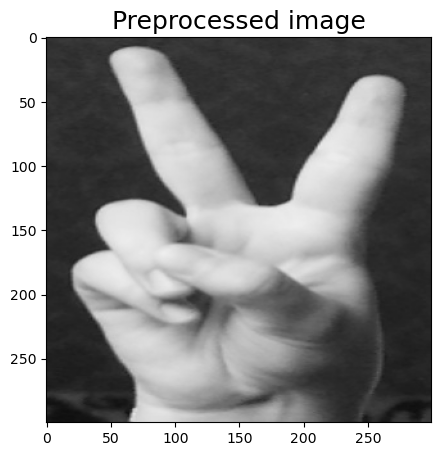

In [90]:
# Preprocessed image from example above
cropped_im_1 = cv2.imread('images/train_preprocessed/peace/' + image_name + '.jpg')

plt.figure(figsize=(5,5))
plt.title('Preprocessed image', fontsize=18)
plt.imshow(cropped_im_1)
plt.show()

## Create train and validation dataset using the 80/20 split

In [7]:
# Defining parameters for loader
img_height = 300
img_width = 300
batch_size = 32

# Creating train dataset
train_data = tf.keras.utils.image_dataset_from_directory(
  'images/train_preprocessed',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Creating validation dataset
validation_data = tf.keras.utils.image_dataset_from_directory(
  'images/train_preprocessed',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 18 classes.
Using 7200 files for training.
Found 9000 files belonging to 18 classes.
Using 1800 files for validation.


## Create and compile model

In [92]:
# Creating model
num_classes = len(validation_data.class_names)

# Data augmentation to replicate more data
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    ])

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

# Compiling model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                

## Train model

In [94]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 30
history = model.fit(train_data, validation_data=validation_data, epochs=epochs)

Epoch 1/30
225/225 [==============================] - 323s 1s/step - loss: 2.7027 - accuracy: 0.1519 - val_loss: 2.2217 - val_accuracy: 0.3206
Epoch 2/30
225/225 [==============================] - 323s 1s/step - loss: 2.0596 - accuracy: 0.3404 - val_loss: 1.4770 - val_accuracy: 0.5256
Epoch 3/30
225/225 [==============================] - 318s 1s/step - loss: 1.6414 - accuracy: 0.4600 - val_loss: 1.2193 - val_accuracy: 0.6194
Epoch 4/30
225/225 [==============================] - 320s 1s/step - loss: 1.4391 - accuracy: 0.5289 - val_loss: 1.0104 - val_accuracy: 0.6783
Epoch 5/30
225/225 [==============================] - 322s 1s/step - loss: 1.2607 - accuracy: 0.5942 - val_loss: 1.0837 - val_accuracy: 0.6533
Epoch 6/30
225/225 [==============================] - 318s 1s/step - loss: 1.1363 - accuracy: 0.6271 - val_loss: 0.8408 - val_accuracy: 0.7239
Epoch 7/30
225/225 [==============================] - 308s 1s/step - loss: 1.0391 - accuracy: 0.6626 - val_loss: 0.7538 - val_accuracy: 0.7650

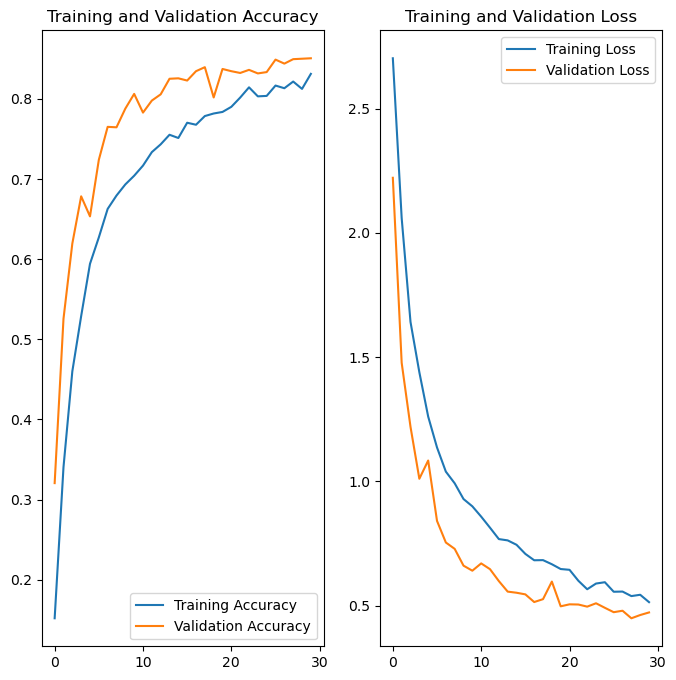

In [96]:
# Vizualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
# Save model
model.save('tf_model/')

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


## Test model with out own images

In [3]:
# Load model
model = keras.models.load_model('tf_model')

1/1 [==============================] - 0s 30ms/step


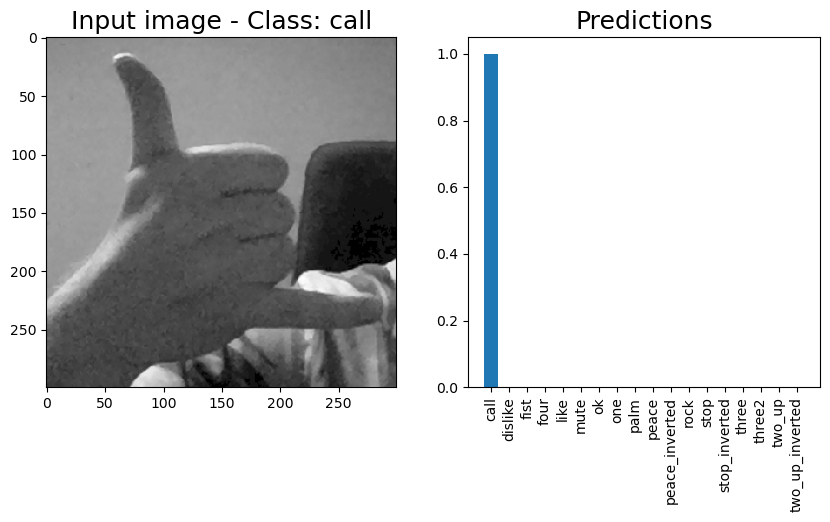

Correct classification! This image most likely belongs to call with a 99.99 percent confidence.
1/1 [==============================] - 0s 30ms/step


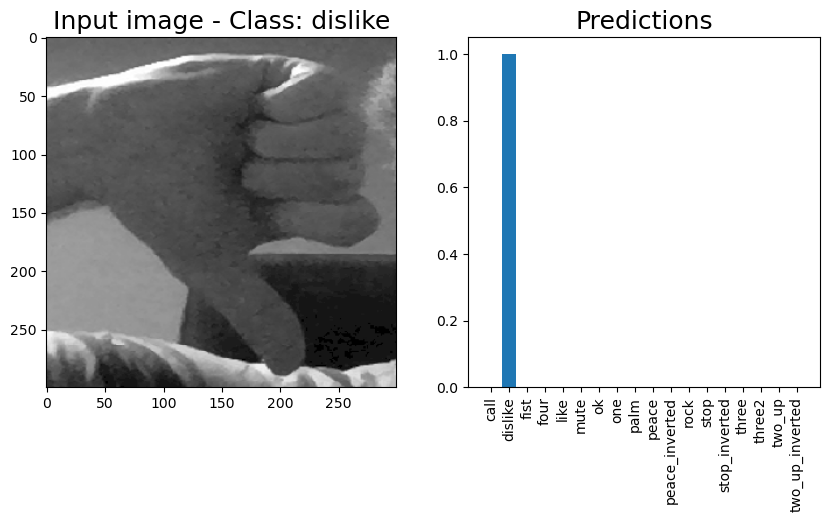

Correct classification! This image most likely belongs to dislike with a 100.00 percent confidence.
1/1 [==============================] - 0s 35ms/step


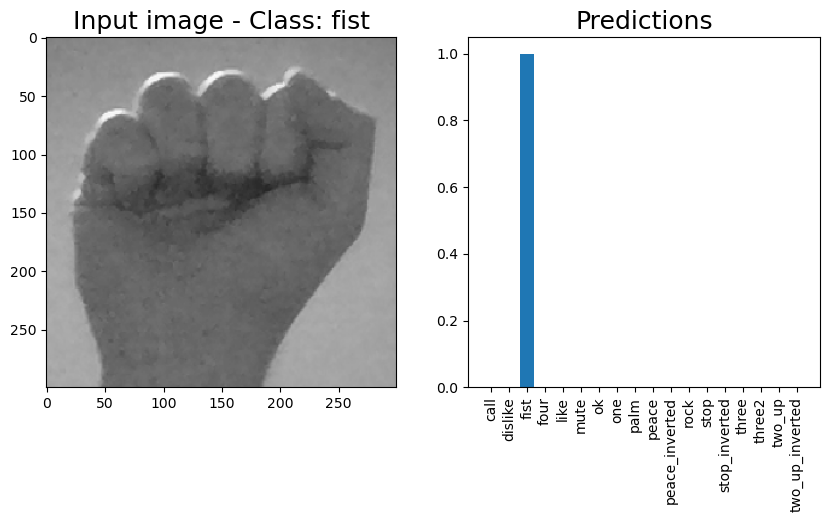

Correct classification! This image most likely belongs to fist with a 99.89 percent confidence.
1/1 [==============================] - 0s 48ms/step


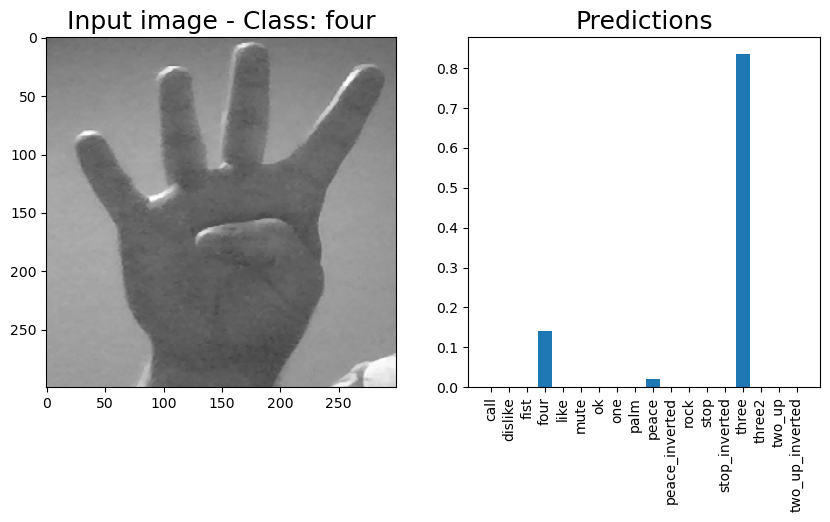

Incorrect classification! This image most likely belongs to three with a 83.54 percent confidence.
1/1 [==============================] - 0s 56ms/step


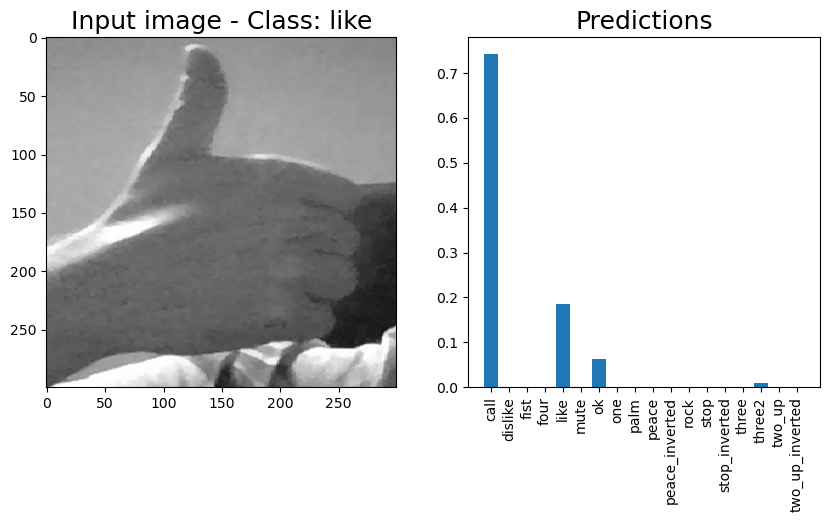

Incorrect classification! This image most likely belongs to call with a 74.25 percent confidence.
1/1 [==============================] - 0s 55ms/step


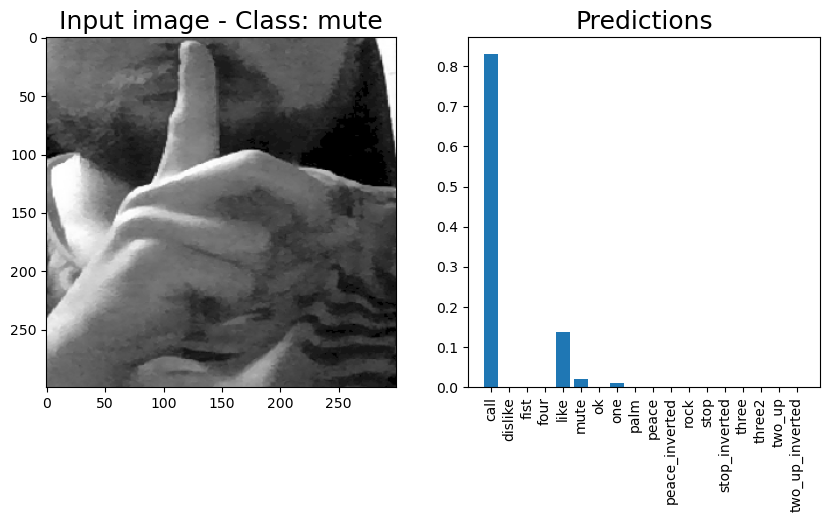

Incorrect classification! This image most likely belongs to call with a 83.06 percent confidence.
1/1 [==============================] - 0s 48ms/step


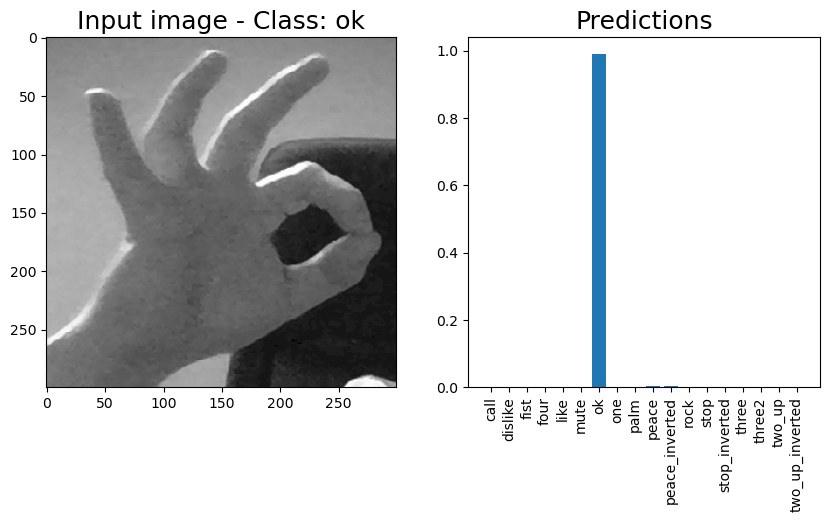

Correct classification! This image most likely belongs to ok with a 99.07 percent confidence.
1/1 [==============================] - 0s 33ms/step


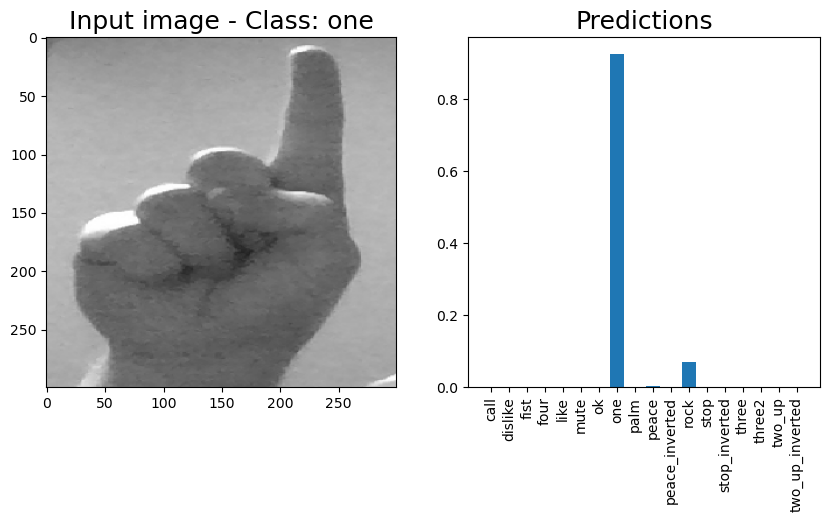

Correct classification! This image most likely belongs to one with a 92.66 percent confidence.
1/1 [==============================] - 0s 47ms/step


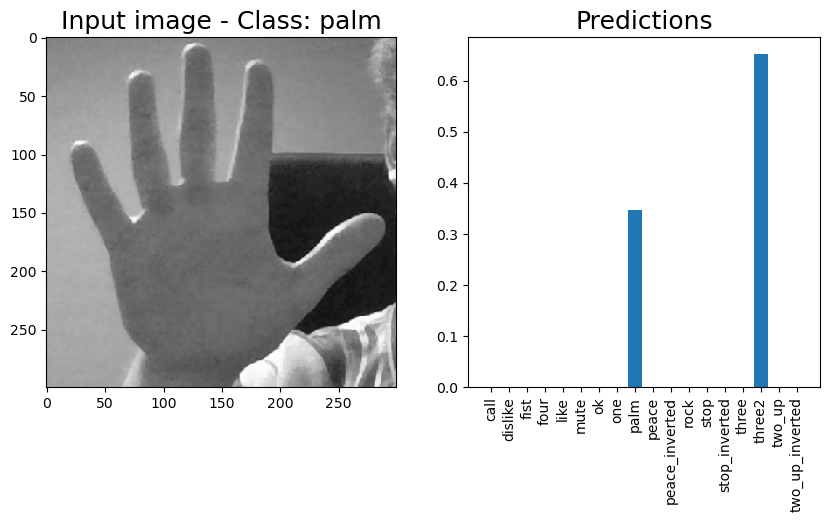

Incorrect classification! This image most likely belongs to three2 with a 65.24 percent confidence.
1/1 [==============================] - 0s 46ms/step


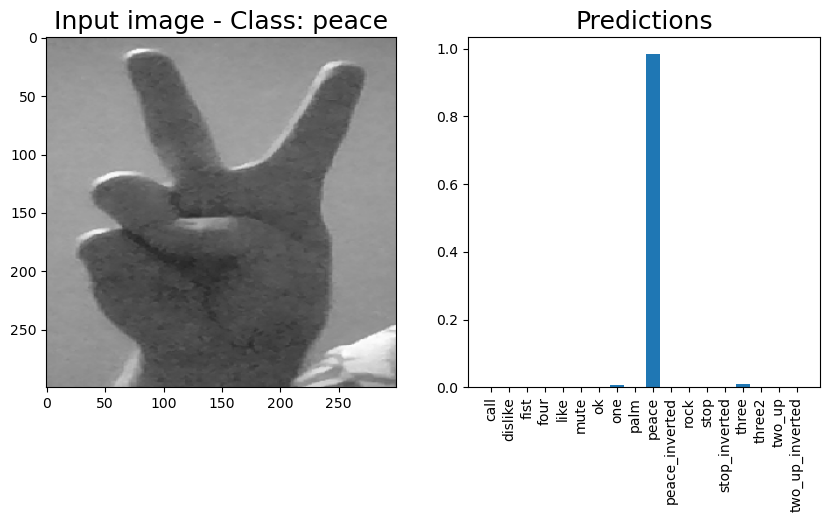

Correct classification! This image most likely belongs to peace with a 98.41 percent confidence.
1/1 [==============================] - 0s 31ms/step


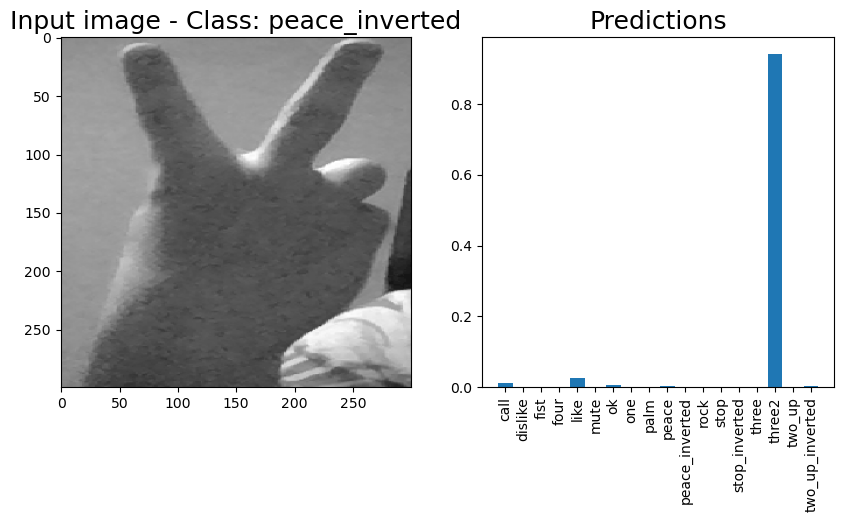

Incorrect classification! This image most likely belongs to three2 with a 94.18 percent confidence.
1/1 [==============================] - 0s 46ms/step


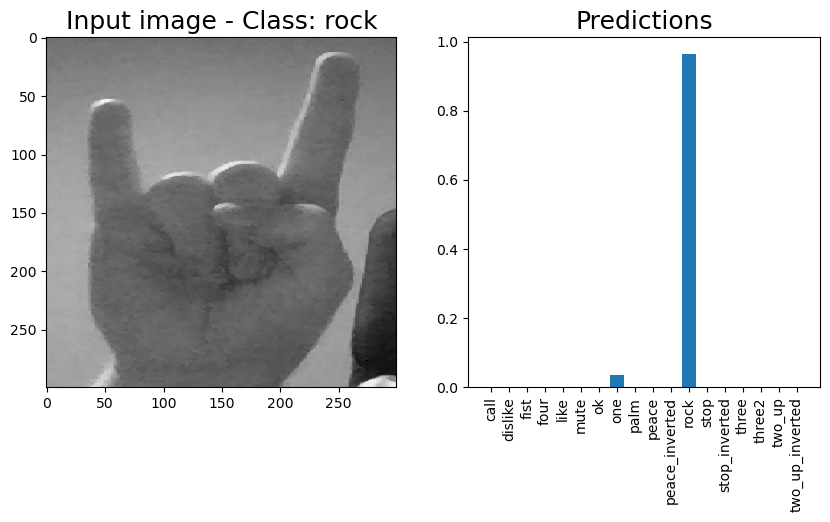

Correct classification! This image most likely belongs to rock with a 96.46 percent confidence.
1/1 [==============================] - 0s 62ms/step


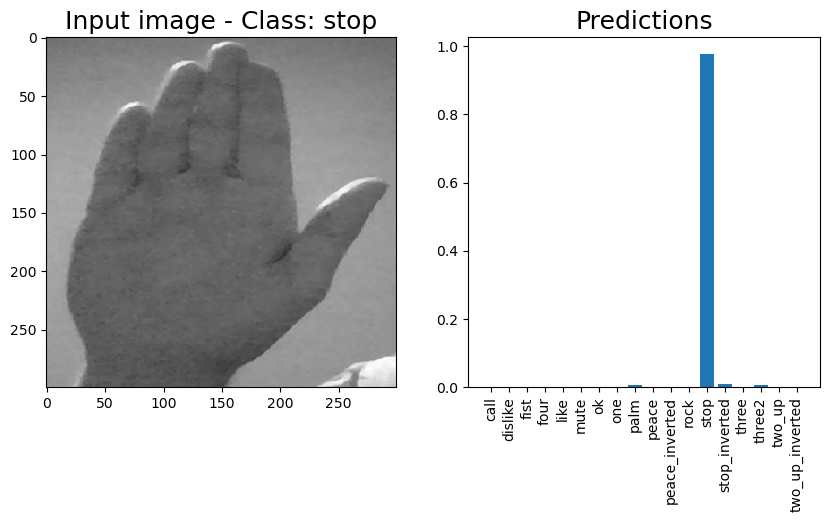

Correct classification! This image most likely belongs to stop with a 97.72 percent confidence.
1/1 [==============================] - 0s 33ms/step


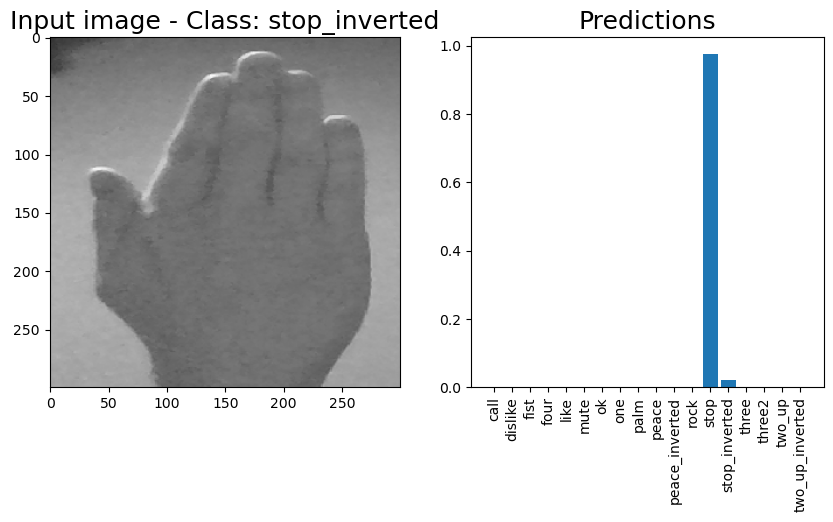

Incorrect classification! This image most likely belongs to stop with a 97.59 percent confidence.
1/1 [==============================] - 0s 33ms/step


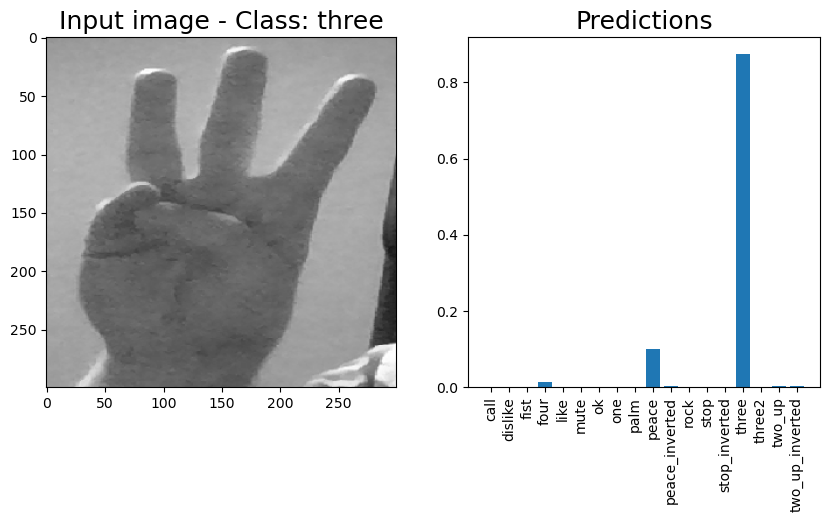

Correct classification! This image most likely belongs to three with a 87.44 percent confidence.
1/1 [==============================] - 0s 39ms/step


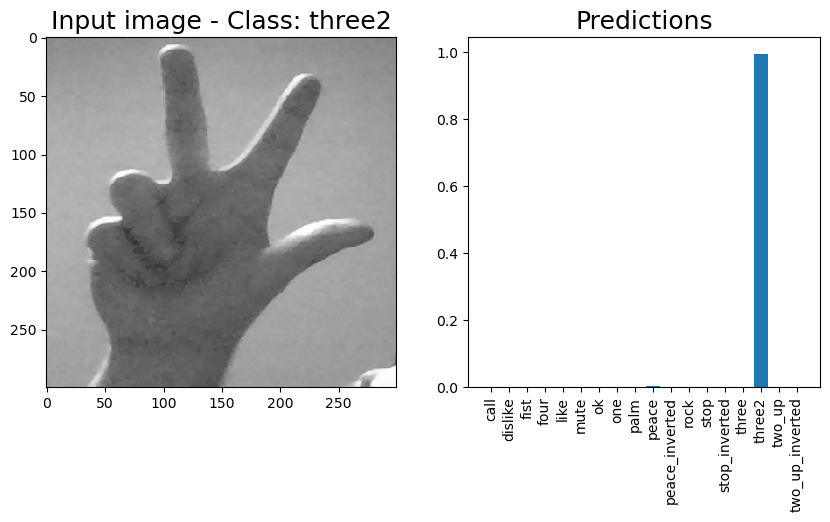

Correct classification! This image most likely belongs to three2 with a 99.56 percent confidence.
1/1 [==============================] - 0s 33ms/step


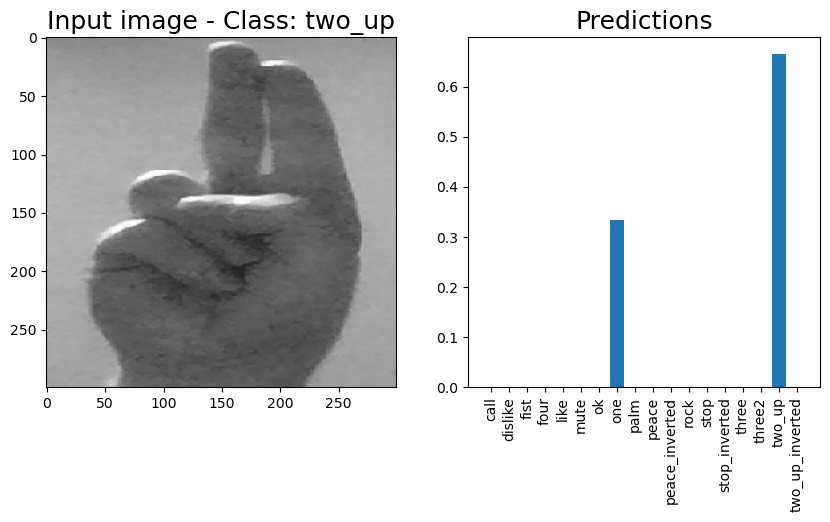

Correct classification! This image most likely belongs to two_up with a 66.53 percent confidence.
1/1 [==============================] - 0s 46ms/step


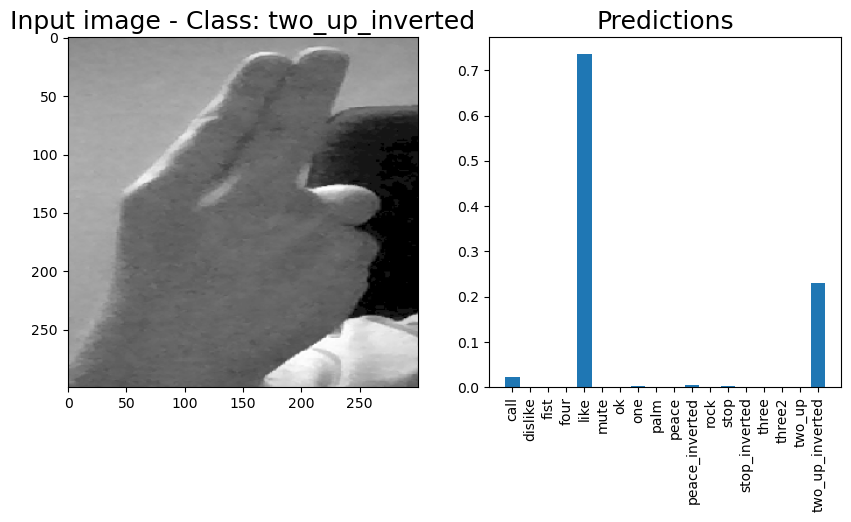

Incorrect classification! This image most likely belongs to like with a 73.63 percent confidence.


In [8]:
# Test with set of manually cropped input images
for name in class_names:
    img = tf.keras.utils.load_img('images/manual_test/grayscale/' + name + '.png', target_size=(300, 300))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_names = train_data.class_names
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title('Input image - Class: ' + name, fontsize=18)
    plt.imshow(img, cmap = 'gray')
    plt.subplot(222)
    plt.title('Predictions', fontsize=18)
    plt.bar(class_names, score)
    plt.xticks(range(len(class_names)), class_names, rotation=90)

    plt.show()
    
    if name == class_names[np.argmax(score)]:
        print("\x1b[1;32mCorrect classification! This image most likely belongs to {} with a {:.2f} percent confidence.\x1b[0m"
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
    else:
        print("\x1b[1;31mIncorrect classification! This image most likely belongs to {} with a {:.2f} percent confidence.\x1b[0m"
        .format(class_names[np.argmax(score)], 100 * np.max(score)))



## Testing and evaluating model with test dataset

In [31]:
# Loading test data
files = []
for file in os.listdir("data/test"):
    if file.endswith(".json"):
        files.append(os.path.join("data/test", file))
        
class_names = [
       'call',
       'dislike',
       'fist',
       'four',
       'like',
       'mute',
       'ok',
       'one',
       'palm',
       'peace',
       'peace_inverted',
       'rock',
       'stop',
       'stop_inverted',
       'three',
       'three2',
       'two_up',
       'two_up_inverted']

test_data = {}

classindex = 0
for file in files:
    current_class = class_names[classindex]
    class_annotations = {}
    with codecs.open(file,'r','utf-8') as f: 
        annotations = json.load(f)
        for annotation in annotations:
            class_annotations[annotation] = annotations[annotation]
    classindex += 1
    data[current_class] = class_annotations

100


In [ ]:
# Preprocessing test data
img_height = 300
img_width = 300
batch_size = 32

# Crop and resize train and validation images
for category in class_names:
    for img_name in data[category]:
        im = cv2.imread('images/test_original/' + category + '/' + img_name + '.jpg', cv2.IMREAD_GRAYSCALE)
        h, w = im.shape[0], im.shape[1]
        iteration = 0
        for bbox in data[category][img_name]['bboxes']:
            start_point = (int(w*bbox[0]) , int(h*bbox[1]))
            end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
            cropped_image = im[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            resized_image = cv2.resize(cropped_image, (img_height, img_width), interpolation= cv2.INTER_LINEAR)
            label = data[category][img_name]['labels'][iteration]
            cv2.imwrite('images/test_preprocessed/' + label + '/' + img_name + '.jpg' , resized_image)
            iteration += 1

In [9]:
# Testing and evaluating model
test_dataset = tf.keras.utils.image_dataset_from_directory(
  'images/test_preprocessed',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, 
  shuffle=False)

predict = model.predict(test_dataset)

Found 1800 files belonging to 18 classes.
57/57 [==============================] - 14s 239ms/step


                 precision    recall  f1-score   support

           call       0.90      0.94      0.92       100
        dislike       0.94      0.93      0.93       100
           fist       0.86      0.96      0.91       100
           four       0.71      0.85      0.78       100
           like       0.85      0.92      0.88       100
           mute       0.94      0.84      0.89       100
             ok       0.85      0.73      0.78       100
            one       0.79      0.82      0.80       100
           palm       0.83      0.89      0.86       100
          peace       0.69      0.64      0.66       100
 peace_inverted       0.90      0.69      0.78       100
           rock       0.78      0.87      0.82       100
           stop       0.77      0.76      0.76       100
  stop_inverted       0.79      0.87      0.83       100
          three       0.67      0.60      0.63       100
         three2       0.85      0.89      0.87       100
         two_up       0.83    

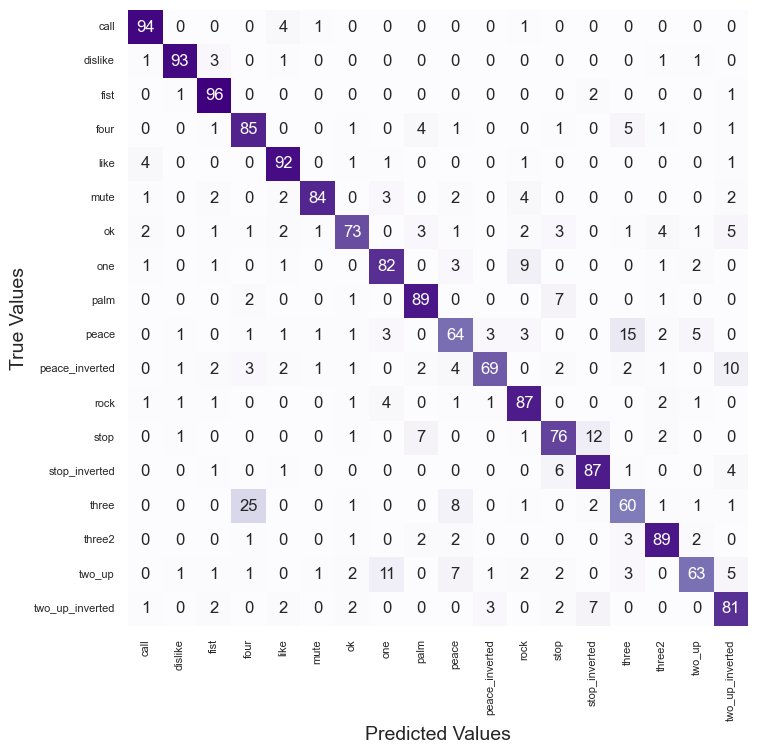

In [19]:
# Define true and predicted categories with id
true_categories_id = tf.concat([y for x, y in test_dataset], axis=0)
predicted_categories_id = np.argmax(predict, axis=-1)

# Change id to classnames
true_categories = []
for x in true_categories_id.numpy():
    true_categories.append(class_names[x])

predicted_categories = []
for x in predicted_categories_id:
    predicted_categories.append(class_names[x])

# Print classification report
print(classification_report(true_categories, predicted_categories))

# Print confusion matrix
cm = confusion_matrix(true_categories, predicted_categories)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cbar = False, cmap='Purples');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
ax1.xaxis.set_ticklabels(class_names, fontsize=8, rotation=90)
ax1.yaxis.set_ticklabels(class_names, fontsize=8, rotation=0)
plt.show()


## Apply model with hand recognizion